<a href="https://colab.research.google.com/github/Deriss/Deteccao_fogo_yolo_v3/blob/main/Deteccao_fogo_yolo_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de fogo com ImageAI e YOLOv3


## Instalar Dependências

In [1]:
!pip install cython pillow>=7.0.0 numpy>=1.18.1 opencv-python>=4.1.2 torch>=1.9.0 --extra-index-url https://download.pytorch.org/whl/cpu torchvision>=0.10.0 --extra-index-url https://download.pytorch.org/whl/cpu pytest==7.1.3 tqdm==4.64.1 scipy>=1.7.3 matplotlib>=3.4.3 mock==4.0.3

In [2]:
# dependência para poder treinar modelo customizado
!pip install pycocotools@git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-install-yowu8kh2/pycocotools_7ddcb7a203344249a78caed13ea3f082
  Running command git clone --filter=blob:none --quiet https://github.com/gautamchitnis/cocoapi.git /tmp/pip-install-yowu8kh2/pycocotools_7ddcb7a203344249a78caed13ea3f082
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
  Resolved https://github.com/gautamchitnis/cocoapi.git to commit 20291f19c46a8d11935862bc9e449a1b72ec25ed
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=379064 sha256=60cee53e1ac2506f2bf6c3576afd81a26e8610cca00dd1074d2efe04b1e55d68
  Stored in directory: /tmp/pip-ephem-wheel-cache-p89lugu1/wheels/83/c2/a9/31695b4858fd20696ebf8ae959a4e447159f8bf667

In [3]:
#instalar imageai
!pip install imageai --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.1 MB/s eta 0:00:00


## Carregar Bibiliotecas

In [24]:
from imageai.Detection import VideoObjectDetection
from imageai.Detection import ObjectDetection
import matplotlib.pyplot as plt
import numpy as np
import scipy


## Conexão com Google Drive

Conectar com o Google Drive para carregar o modelo [YOLO v3]() já treinado e disponibilizado pela ImageAI.
Também foram armazenadas as imagens para o retreinamento do modelo para a detecção de fogo, obtidas do dataset [Fire Dataset in Yolo Format](https://www.kaggle.com/datasets/antrosafin/fire-dataset-in-yolo-format) disponibilizado no Kaggle.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Testando modelo YOLO v3: detecção a partir de uma imagem

In [11]:
image_detector = ObjectDetection()
image_detector.setModelTypeAsYOLOv3()
image_detector.setModelPath("/content/drive/MyDrive/IoT/yolov3.pt")
image_detector.loadModel()


In [12]:
detections = image_detector.detectObjectsFromImage(input_image="/content/drive/MyDrive/IoT/FireData/Fire_data/test/images/fire.25.png",
                                                   output_image_path="/content/drive/MyDrive/IoT/testfire.png", minimum_percentage_probability=50,output_type="file")

In [13]:
detections

[{'name': 'person',
  'percentage_probability': 99.9,
  'box_points': [445, 27, 578, 340]}]

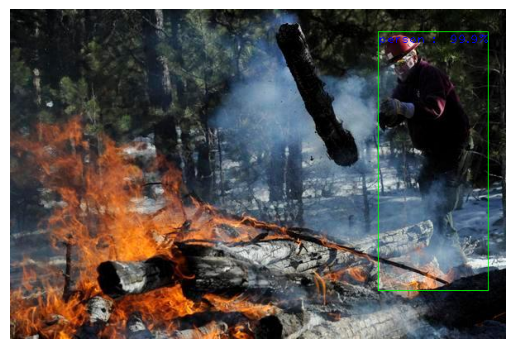

In [27]:
img = plt.imread('/content/drive/MyDrive/IoT/testfire.png')
plt.imshow(img)
plt.axis('off')
plt.show()

O modelo reconhece corretamente a pessoa mas não permite a detecção do fogo no imagem

## Testando modelo YOLO v3: detecção a partir de um video

In [28]:
detector = VideoObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("/content/drive/MyDrive/IoT/yolov3.pt")
detector.loadModel()


In [31]:
video_path = detector.detectObjectsFromVideo(input_file_path="/content/drive/MyDrive/IoT/bonfire_-_1808 (360p).mp4",
                                      output_file_path="/content/drive/MyDrive/IoT/fire_video_yolov3_output",
                                      frames_per_second=30 ,
                                      minimum_percentage_probability=40)

# Treinar modelo customizado para a detecção de fogo

ImageAI oferece uma forma simples de treinar um modelo para a detecção de novos objetos a partir de uma rede já treinada. Para isso, é preciso ter as imagens já anotadas em formato YOLO e organizadas em pastas para treino, validação e teste como indicado na [documentação](https://imageai.readthedocs.io/en/latest/customdetection/index.html). Nesse projeto, foram utilizas as imagens disponíveis no dataset [Fire Data in YOLO format](https://www.kaggle.com/datasets/antrosafin/fire-dataset-in-yolo-format) no Kaggle. Este dataset contém 300 imagens de fogo já anotadas para treino, 10 para validação e 52 para teste.

In [14]:
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="/content/drive/MyDrive/IoT/FireData/Fire_data")
trainer.setTrainConfig(object_names_array=["fire"], batch_size=4, num_experiments=50, train_from_pretrained_model="/content/drive/MyDrive/IoT/yolov3.pt")
trainer.trainModel()

Generating anchor boxes for training images...
thr=0.25: 0.9994 best possible recall, 5.70 anchors past thr
n=9, img_size=416, metric_all=0.362/0.734-mean/best, past_thr=0.483-mean: 
Pretrained YOLOv3 model loaded to initialize weights
Epoch 1/50
----------
Train: 


75it [00:14,  5.13it/s]


    box loss-> 0.11442, object loss-> 0.23492, class loss-> 0.00000
Validation:


5it [00:39,  7.91s/it]


    recall: 0.029851 precision: 0.001516 mAP@0.5: 0.000715, mAP@0.5-0.95: 0.000177

Epoch 2/50
----------
Train: 


75it [00:13,  5.58it/s]


    box loss-> 0.10859, object loss-> 0.09318, class loss-> 0.00000
Validation:


5it [00:34,  6.90s/it]


    recall: 0.179104 precision: 0.004728 mAP@0.5: 0.002503, mAP@0.5-0.95: 0.000376

Epoch 3/50
----------
Train: 


75it [00:13,  5.63it/s]


    box loss-> 0.10628, object loss-> 0.08846, class loss-> 0.00000
Validation:


5it [00:30,  6.01s/it]


    recall: 0.074627 precision: 0.026128 mAP@0.5: 0.004766, mAP@0.5-0.95: 0.000777

Epoch 4/50
----------
Train: 


75it [00:13,  5.73it/s]


    box loss-> 0.10468, object loss-> 0.08416, class loss-> 0.00000
Validation:


5it [00:27,  5.60s/it]


    recall: 0.089552 precision: 0.036002 mAP@0.5: 0.007834, mAP@0.5-0.95: 0.001415

Epoch 5/50
----------
Train: 


75it [00:13,  5.68it/s]


    box loss-> 0.10198, object loss-> 0.08093, class loss-> 0.00000
Validation:


5it [00:25,  5.17s/it]


    recall: 0.059701 precision: 0.044392 mAP@0.5: 0.016118, mAP@0.5-0.95: 0.002655

Epoch 6/50
----------
Train: 


75it [00:12,  5.93it/s]


    box loss-> 0.09989, object loss-> 0.07965, class loss-> 0.00000
Validation:


5it [00:23,  4.78s/it]


    recall: 0.089552 precision: 0.093725 mAP@0.5: 0.022882, mAP@0.5-0.95: 0.004289

Epoch 7/50
----------
Train: 


75it [00:12,  5.99it/s]


    box loss-> 0.09688, object loss-> 0.07929, class loss-> 0.00000
Validation:


5it [00:23,  4.76s/it]


    recall: 0.104478 precision: 0.142295 mAP@0.5: 0.039059, mAP@0.5-0.95: 0.005895

Epoch 8/50
----------
Train: 


75it [00:12,  5.81it/s]


    box loss-> 0.09358, object loss-> 0.07964, class loss-> 0.00000
Validation:


5it [00:22,  4.49s/it]


    recall: 0.134328 precision: 0.154880 mAP@0.5: 0.042686, mAP@0.5-0.95: 0.007661

Epoch 9/50
----------
Train: 


75it [00:12,  5.79it/s]


    box loss-> 0.09044, object loss-> 0.07919, class loss-> 0.00000
Validation:


5it [00:23,  4.64s/it]


    recall: 0.104478 precision: 0.152702 mAP@0.5: 0.061390, mAP@0.5-0.95: 0.010791

Epoch 10/50
----------
Train: 


75it [00:12,  6.03it/s]


    box loss-> 0.08807, object loss-> 0.07623, class loss-> 0.00000
Validation:


5it [00:18,  3.61s/it]


    recall: 0.208955 precision: 0.088366 mAP@0.5: 0.067811, mAP@0.5-0.95: 0.013359

Epoch 11/50
----------
Train: 


75it [00:12,  5.79it/s]


    box loss-> 0.08522, object loss-> 0.07250, class loss-> 0.00000
Validation:


5it [00:18,  3.72s/it]


    recall: 0.162442 precision: 0.099948 mAP@0.5: 0.062560, mAP@0.5-0.95: 0.015088

Epoch 12/50
----------
Train: 


75it [00:12,  6.14it/s]


    box loss-> 0.08000, object loss-> 0.07212, class loss-> 0.00000
Validation:


5it [00:18,  3.65s/it]


    recall: 0.253731 precision: 0.113219 mAP@0.5: 0.061751, mAP@0.5-0.95: 0.013351

Epoch 13/50
----------
Train: 


75it [00:11,  6.28it/s]


    box loss-> 0.07909, object loss-> 0.07102, class loss-> 0.00000
Validation:


5it [00:14,  2.91s/it]


    recall: 0.104478 precision: 0.178495 mAP@0.5: 0.038080, mAP@0.5-0.95: 0.008837

Epoch 14/50
----------
Train: 


75it [00:12,  6.20it/s]


    box loss-> 0.08130, object loss-> 0.08700, class loss-> 0.00000
Validation:


5it [00:16,  3.29s/it]


    recall: 0.208955 precision: 0.097209 mAP@0.5: 0.041885, mAP@0.5-0.95: 0.007899

Epoch 15/50
----------
Train: 


75it [00:11,  6.55it/s]


    box loss-> 0.07265, object loss-> 0.07015, class loss-> 0.00000
Validation:


5it [00:15,  3.04s/it]


    recall: 0.194030 precision: 0.133993 mAP@0.5: 0.072276, mAP@0.5-0.95: 0.012826

Epoch 16/50
----------
Train: 


75it [00:12,  6.00it/s]


    box loss-> 0.06776, object loss-> 0.06709, class loss-> 0.00000
Validation:


5it [00:16,  3.22s/it]


    recall: 0.179104 precision: 0.148614 mAP@0.5: 0.076966, mAP@0.5-0.95: 0.015439

Epoch 17/50
----------
Train: 


75it [00:12,  5.97it/s]


    box loss-> 0.06558, object loss-> 0.06482, class loss-> 0.00000
Validation:


5it [00:13,  2.80s/it]


    recall: 0.223881 precision: 0.140008 mAP@0.5: 0.068038, mAP@0.5-0.95: 0.014492

Epoch 18/50
----------
Train: 


75it [00:11,  6.44it/s]


    box loss-> 0.06363, object loss-> 0.06375, class loss-> 0.00000
Validation:


5it [00:14,  2.91s/it]


    recall: 0.164179 precision: 0.130006 mAP@0.5: 0.058905, mAP@0.5-0.95: 0.011744

Epoch 19/50
----------
Train: 


75it [00:12,  5.87it/s]


    box loss-> 0.06073, object loss-> 0.06135, class loss-> 0.00000
Validation:


5it [00:12,  2.52s/it]


    recall: 0.149254 precision: 0.188604 mAP@0.5: 0.075708, mAP@0.5-0.95: 0.017509

Epoch 20/50
----------
Train: 


75it [00:11,  6.51it/s]


    box loss-> 0.05870, object loss-> 0.05926, class loss-> 0.00000
Validation:


5it [00:12,  2.45s/it]


    recall: 0.179104 precision: 0.155684 mAP@0.5: 0.089126, mAP@0.5-0.95: 0.016116

Epoch 21/50
----------
Train: 


75it [00:12,  5.93it/s]


    box loss-> 0.05598, object loss-> 0.05802, class loss-> 0.00000
Validation:


5it [00:11,  2.29s/it]


    recall: 0.164179 precision: 0.273789 mAP@0.5: 0.101380, mAP@0.5-0.95: 0.020893

Epoch 22/50
----------
Train: 


75it [00:12,  5.93it/s]


    box loss-> 0.05364, object loss-> 0.05626, class loss-> 0.00000
Validation:


5it [00:10,  2.09s/it]


    recall: 0.164179 precision: 0.224472 mAP@0.5: 0.098603, mAP@0.5-0.95: 0.021421

Epoch 23/50
----------
Train: 


75it [00:12,  6.15it/s]


    box loss-> 0.05233, object loss-> 0.05470, class loss-> 0.00000
Validation:


5it [00:09,  1.89s/it]


    recall: 0.149254 precision: 0.284923 mAP@0.5: 0.102133, mAP@0.5-0.95: 0.021288

Epoch 24/50
----------
Train: 


75it [00:12,  6.06it/s]


    box loss-> 0.05160, object loss-> 0.05455, class loss-> 0.00000
Validation:


5it [00:09,  1.95s/it]


    recall: 0.268657 precision: 0.233742 mAP@0.5: 0.133678, mAP@0.5-0.95: 0.022976

Epoch 25/50
----------
Train: 


75it [00:12,  5.85it/s]


    box loss-> 0.04838, object loss-> 0.05313, class loss-> 0.00000
Validation:


5it [00:10,  2.03s/it]


    recall: 0.194030 precision: 0.301659 mAP@0.5: 0.128359, mAP@0.5-0.95: 0.023228

Epoch 26/50
----------
Train: 


75it [00:11,  6.33it/s]


    box loss-> 0.04885, object loss-> 0.05271, class loss-> 0.00000
Validation:


5it [00:08,  1.78s/it]


    recall: 0.313433 precision: 0.222943 mAP@0.5: 0.153391, mAP@0.5-0.95: 0.026878

Epoch 27/50
----------
Train: 


75it [00:12,  6.01it/s]


    box loss-> 0.04749, object loss-> 0.05216, class loss-> 0.00000
Validation:


5it [00:09,  1.90s/it]


    recall: 0.178287 precision: 0.314777 mAP@0.5: 0.116578, mAP@0.5-0.95: 0.022593

Epoch 28/50
----------
Train: 


75it [00:12,  6.20it/s]


    box loss-> 0.04599, object loss-> 0.05100, class loss-> 0.00000
Validation:


5it [00:09,  1.94s/it]


    recall: 0.164179 precision: 0.259545 mAP@0.5: 0.100350, mAP@0.5-0.95: 0.018634

Epoch 29/50
----------
Train: 


75it [00:11,  6.51it/s]


    box loss-> 0.04296, object loss-> 0.04944, class loss-> 0.00000
Validation:


5it [00:08,  1.69s/it]


    recall: 0.178787 precision: 0.196436 mAP@0.5: 0.097981, mAP@0.5-0.95: 0.019971

Epoch 30/50
----------
Train: 


75it [00:13,  5.71it/s]


    box loss-> 0.04233, object loss-> 0.04792, class loss-> 0.00000
Validation:


5it [00:08,  1.75s/it]


    recall: 0.328358 precision: 0.169008 mAP@0.5: 0.133051, mAP@0.5-0.95: 0.029107

Epoch 31/50
----------
Train: 


75it [00:12,  5.80it/s]


    box loss-> 0.04018, object loss-> 0.04652, class loss-> 0.00000
Validation:


5it [00:07,  1.52s/it]


    recall: 0.194030 precision: 0.244450 mAP@0.5: 0.118277, mAP@0.5-0.95: 0.027219

Epoch 32/50
----------
Train: 


75it [00:12,  6.13it/s]


    box loss-> 0.03934, object loss-> 0.04623, class loss-> 0.00000
Validation:


5it [00:08,  1.71s/it]


    recall: 0.163587 precision: 0.261190 mAP@0.5: 0.102718, mAP@0.5-0.95: 0.022588

Epoch 33/50
----------
Train: 


75it [00:11,  6.29it/s]


    box loss-> 0.03937, object loss-> 0.04599, class loss-> 0.00000
Validation:


5it [00:07,  1.46s/it]


    recall: 0.164179 precision: 0.267770 mAP@0.5: 0.099238, mAP@0.5-0.95: 0.021891

Epoch 34/50
----------
Train: 


75it [00:12,  6.15it/s]


    box loss-> 0.03911, object loss-> 0.04527, class loss-> 0.00000
Validation:


5it [00:08,  1.66s/it]


    recall: 0.164179 precision: 0.192011 mAP@0.5: 0.093338, mAP@0.5-0.95: 0.019589

Epoch 35/50
----------
Train: 


75it [00:11,  6.29it/s]


    box loss-> 0.03683, object loss-> 0.04395, class loss-> 0.00000
Validation:


5it [00:07,  1.43s/it]


    recall: 0.149254 precision: 0.321972 mAP@0.5: 0.113338, mAP@0.5-0.95: 0.021629

Epoch 36/50
----------
Train: 


75it [00:12,  6.22it/s]


    box loss-> 0.03598, object loss-> 0.04345, class loss-> 0.00000
Validation:


5it [00:07,  1.46s/it]


    recall: 0.134328 precision: 0.428386 mAP@0.5: 0.120751, mAP@0.5-0.95: 0.026380

Epoch 37/50
----------
Train: 


75it [00:11,  6.55it/s]


    box loss-> 0.03622, object loss-> 0.04323, class loss-> 0.00000
Validation:


5it [00:07,  1.55s/it]


    recall: 0.268657 precision: 0.174695 mAP@0.5: 0.123861, mAP@0.5-0.95: 0.026104

Epoch 38/50
----------
Train: 


75it [00:12,  6.15it/s]


    box loss-> 0.03479, object loss-> 0.04271, class loss-> 0.00000
Validation:


5it [00:06,  1.31s/it]


    recall: 0.253731 precision: 0.193137 mAP@0.5: 0.120049, mAP@0.5-0.95: 0.024526

Epoch 39/50
----------
Train: 


75it [00:12,  6.19it/s]


    box loss-> 0.03333, object loss-> 0.04149, class loss-> 0.00000
Validation:


5it [00:07,  1.50s/it]


    recall: 0.149254 precision: 0.321117 mAP@0.5: 0.116714, mAP@0.5-0.95: 0.022395

Epoch 40/50
----------
Train: 


75it [00:12,  6.25it/s]


    box loss-> 0.03262, object loss-> 0.04107, class loss-> 0.00000
Validation:


5it [00:06,  1.29s/it]


    recall: 0.268116 precision: 0.154906 mAP@0.5: 0.118029, mAP@0.5-0.95: 0.025692

Epoch 41/50
----------
Train: 


75it [00:11,  6.35it/s]


    box loss-> 0.03226, object loss-> 0.04030, class loss-> 0.00000
Validation:


5it [00:06,  1.34s/it]


    recall: 0.179104 precision: 0.266582 mAP@0.5: 0.120763, mAP@0.5-0.95: 0.026528

Epoch 42/50
----------
Train: 


75it [00:11,  6.42it/s]


    box loss-> 0.03147, object loss-> 0.03975, class loss-> 0.00000
Validation:


5it [00:07,  1.47s/it]


    recall: 0.149254 precision: 0.356787 mAP@0.5: 0.120829, mAP@0.5-0.95: 0.025018

Epoch 43/50
----------
Train: 


75it [00:13,  5.73it/s]


    box loss-> 0.03085, object loss-> 0.03914, class loss-> 0.00000
Validation:


5it [00:06,  1.21s/it]


    recall: 0.238806 precision: 0.189918 mAP@0.5: 0.106077, mAP@0.5-0.95: 0.020098

Epoch 44/50
----------
Train: 


75it [00:12,  6.16it/s]


    box loss-> 0.03029, object loss-> 0.03869, class loss-> 0.00000
Validation:


5it [00:08,  1.66s/it]


    recall: 0.223421 precision: 0.210921 mAP@0.5: 0.117068, mAP@0.5-0.95: 0.023418

Epoch 45/50
----------
Train: 


75it [00:12,  6.24it/s]


    box loss-> 0.03001, object loss-> 0.03830, class loss-> 0.00000
Validation:


5it [00:06,  1.21s/it]


    recall: 0.268657 precision: 0.214185 mAP@0.5: 0.130324, mAP@0.5-0.95: 0.024604

Epoch 46/50
----------
Train: 


75it [00:12,  6.14it/s]


    box loss-> 0.02984, object loss-> 0.03796, class loss-> 0.00000
Validation:


5it [00:06,  1.21s/it]


    recall: 0.134328 precision: 0.358618 mAP@0.5: 0.105705, mAP@0.5-0.95: 0.021195

Epoch 47/50
----------
Train: 


75it [00:12,  6.18it/s]


    box loss-> 0.02929, object loss-> 0.03770, class loss-> 0.00000
Validation:


5it [00:06,  1.39s/it]


    recall: 0.223694 precision: 0.230619 mAP@0.5: 0.132501, mAP@0.5-0.95: 0.026572

Epoch 48/50
----------
Train: 


75it [00:12,  6.16it/s]


    box loss-> 0.02876, object loss-> 0.03715, class loss-> 0.00000
Validation:


5it [00:05,  1.17s/it]


    recall: 0.148847 precision: 0.332706 mAP@0.5: 0.114759, mAP@0.5-0.95: 0.021174

Epoch 49/50
----------
Train: 


75it [00:11,  6.26it/s]


    box loss-> 0.02883, object loss-> 0.03690, class loss-> 0.00000
Validation:


5it [00:05,  1.17s/it]


    recall: 0.179104 precision: 0.239334 mAP@0.5: 0.120613, mAP@0.5-0.95: 0.023096

Epoch 50/50
----------
Train: 


75it [00:12,  6.19it/s]


    box loss-> 0.02849, object loss-> 0.03671, class loss-> 0.00000
Validation:


5it [00:07,  1.45s/it]


    recall: 0.194030 precision: 0.244972 mAP@0.5: 0.128098, mAP@0.5-0.95: 0.024593

Training completed in 21m 38s


# Detecção a partir de imagem utilizando modelo customizado

In [16]:
from imageai.Detection.Custom import CustomObjectDetection

custom_detector = CustomObjectDetection()
custom_detector.setModelTypeAsYOLOv3()
custom_detector.setModelPath("/content/drive/MyDrive/IoT/FireData/Fire_data/models/yolov3_Fire_data_last.pt")
custom_detector.setJsonPath("/content/drive/MyDrive/IoT/FireData/Fire_data/json/Fire_data_yolov3_detection_config.json")
custom_detector.loadModel()
detections = custom_detector.detectObjectsFromImage(input_image="/content/drive/MyDrive/IoT/FireData/Fire_data/test/images/fire.25.png", output_image_path="/content/drive/MyDrive/IoT/testfire_custom.png", minimum_percentage_probability=50,output_type="file")
for detection in detections:
  print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

fire  :  54.62  :  [69, 184, 181, 300]
fire  :  51.9  :  [480, 313, 515, 341]
fire  :  53.7  :  [21, 330, 113, 376]
fire  :  60.64  :  [25, 352, 108, 396]


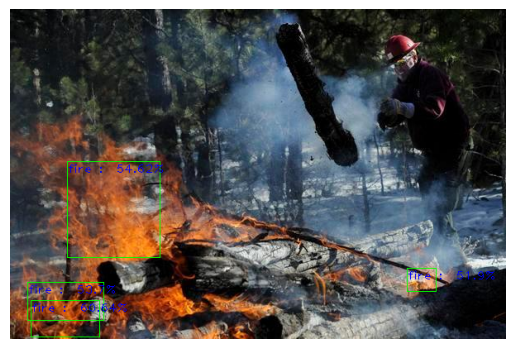

In [32]:
img = plt.imread('/content/drive/MyDrive/IoT/testfire_custom.png')
plt.imshow(img)
plt.axis('off')
plt.show()

O modelo consegue detectar parcialmente o fogo na imagem, porém com uma precisão baixa.

# Detecção a partir de videos utilizando modelo customizado

O modelo foi testado para os seguintes videos:

- [Video 1](https://pixabay.com/videos/bonfire-beach-campfire-camp-sand-1808/): Fogueira na areia

- [Video 2](https://www.pexels.com/video/aerial-view-of-a-factory-emitting-smoke-6186411/): Pequeno forno industrial emitindo fogo e fumaça

- [Video 3](https://www.pexels.com/video/high-angle-view-of-building-in-fire-9780683/): Incêndio em um prédio

### Video 1: Fogueira na areia

In [19]:
from imageai.Detection.Custom import CustomVideoObjectDetection

video_detector = CustomVideoObjectDetection()
video_detector.setModelTypeAsYOLOv3()
video_detector.setModelPath("/content/drive/MyDrive/IoT/FireData/Fire_data/models/yolov3_Fire_data_last.pt")
video_detector.setJsonPath("/content/drive/MyDrive/IoT/FireData/Fire_data/json/Fire_data_yolov3_detection_config.json")
video_detector.loadModel()

video_detector.detectObjectsFromVideo(input_file_path="/content/drive/MyDrive/IoT/bonfire_-_1808 (360p).mp4",
                                      output_file_path="/content/drive/MyDrive/IoT/fire_video_output",
                                      frames_per_second=30 ,
                                      minimum_percentage_probability=40,
                                      log_progress=True)

Processing Frame :  1
Processing Frame :  2
Processing Frame :  3
Processing Frame :  4
Processing Frame :  5
Processing Frame :  6
Processing Frame :  7
Processing Frame :  8
Processing Frame :  9
Processing Frame :  10
Processing Frame :  11
Processing Frame :  12
Processing Frame :  13
Processing Frame :  14
Processing Frame :  15
Processing Frame :  16
Processing Frame :  17
Processing Frame :  18
Processing Frame :  19
Processing Frame :  20
Processing Frame :  21
Processing Frame :  22
Processing Frame :  23
Processing Frame :  24
Processing Frame :  25
Processing Frame :  26
Processing Frame :  27
Processing Frame :  28
Processing Frame :  29
Processing Frame :  30
Processing Frame :  31
Processing Frame :  32
Processing Frame :  33
Processing Frame :  34
Processing Frame :  35
Processing Frame :  36
Processing Frame :  37
Processing Frame :  38
Processing Frame :  39
Processing Frame :  40
Processing Frame :  41
Processing Frame :  42
Processing Frame :  43
Processing Frame :  

'/content/drive/MyDrive/IoT/fire_video_output.mp4.mp4'

In [36]:
import cv2
import random

In [38]:
vidcap = cv2.VideoCapture("/content/drive/MyDrive/IoT/fire_video_output.mp4.mp4")
# get total number of frames
totalFrames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
randomFrameNumber=random.randint(0, totalFrames)
# set frame position
vidcap.set(cv2.CAP_PROP_POS_FRAMES,randomFrameNumber)
success, image = vidcap.read()
if success:
    cv2.imwrite("/content/drive/MyDrive/IoT/fire_video_random_frame.png", image)

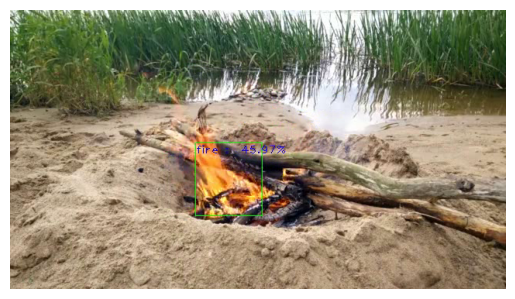

In [39]:
img = plt.imread('/content/drive/MyDrive/IoT/fire_video_random_frame.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## Video 2: Pequeno forno industrial emitindo fogo e fumaça

In [22]:
## Video 2

video_detector.detectObjectsFromVideo(input_file_path="/content/drive/MyDrive/IoT/pexels-tom-fisk-6186411 (360p).mp4",
                                      output_file_path="/content/drive/MyDrive/IoT/fire_video_2_output",
                                      frames_per_second=30 ,
                                      minimum_percentage_probability=40,
                                      log_progress=True)



Processing Frame :  1
Processing Frame :  2
Processing Frame :  3
Processing Frame :  4
Processing Frame :  5
Processing Frame :  6
Processing Frame :  7
Processing Frame :  8
Processing Frame :  9
Processing Frame :  10
Processing Frame :  11
Processing Frame :  12
Processing Frame :  13
Processing Frame :  14
Processing Frame :  15
Processing Frame :  16
Processing Frame :  17
Processing Frame :  18
Processing Frame :  19
Processing Frame :  20
Processing Frame :  21
Processing Frame :  22
Processing Frame :  23
Processing Frame :  24
Processing Frame :  25
Processing Frame :  26
Processing Frame :  27
Processing Frame :  28
Processing Frame :  29
Processing Frame :  30
Processing Frame :  31
Processing Frame :  32
Processing Frame :  33
Processing Frame :  34
Processing Frame :  35
Processing Frame :  36
Processing Frame :  37
Processing Frame :  38
Processing Frame :  39
Processing Frame :  40
Processing Frame :  41
Processing Frame :  42
Processing Frame :  43
Processing Frame :  

'/content/drive/MyDrive/IoT/fire_video_2_output.mp4'

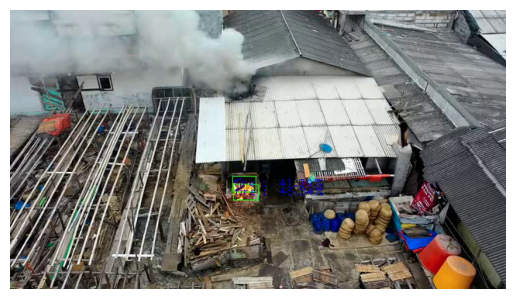

In [41]:
img = plt.imread('/content/drive/MyDrive/IoT/fire_video_2_random_frame.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## Video 3: Incêndio em um prédio

In [23]:
## Video 3

video_detector.detectObjectsFromVideo(input_file_path="/content/drive/MyDrive/IoT/pexels-vyacheslav-prisichev-9780683 (360p).mp4",
                                      output_file_path="/content/drive/MyDrive/IoT/fire_video_3_output",
                                      frames_per_second=30 ,
                                      minimum_percentage_probability=40,
                                      log_progress=True)

Processing Frame :  1
Processing Frame :  2
Processing Frame :  3
Processing Frame :  4
Processing Frame :  5
Processing Frame :  6
Processing Frame :  7
Processing Frame :  8
Processing Frame :  9
Processing Frame :  10
Processing Frame :  11
Processing Frame :  12
Processing Frame :  13
Processing Frame :  14
Processing Frame :  15
Processing Frame :  16
Processing Frame :  17
Processing Frame :  18
Processing Frame :  19
Processing Frame :  20
Processing Frame :  21
Processing Frame :  22
Processing Frame :  23
Processing Frame :  24
Processing Frame :  25
Processing Frame :  26
Processing Frame :  27
Processing Frame :  28
Processing Frame :  29
Processing Frame :  30
Processing Frame :  31
Processing Frame :  32
Processing Frame :  33
Processing Frame :  34
Processing Frame :  35
Processing Frame :  36
Processing Frame :  37
Processing Frame :  38
Processing Frame :  39
Processing Frame :  40
Processing Frame :  41
Processing Frame :  42
Processing Frame :  43
Processing Frame :  

'/content/drive/MyDrive/IoT/fire_video_3_output.mp4'

In [42]:
vidcap = cv2.VideoCapture("/content/drive/MyDrive/IoT/fire_video_3_output.mp4")
# get total number of frames
totalFrames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
randomFrameNumber=random.randint(0, totalFrames)
# set frame position
vidcap.set(cv2.CAP_PROP_POS_FRAMES,randomFrameNumber)
success, image = vidcap.read()
if success:
    cv2.imwrite("/content/drive/MyDrive/IoT/fire_video_3_random_frame.png", image)


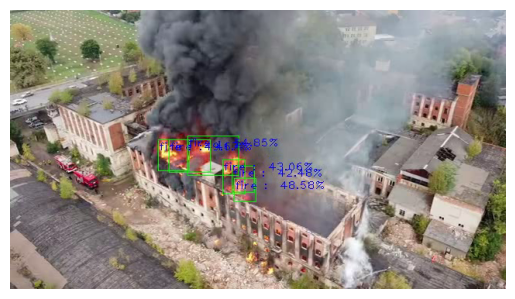

In [43]:
img = plt.imread('/content/drive/MyDrive/IoT/fire_video_3_random_frame.png')
plt.imshow(img)
plt.axis('off')
plt.show()